# qPCR Processing and Plotting Pipeline (Final Fixed)

This notebook handles qPCR data processing and multi-primer comparative plotting. It automatically normalizes data against a reference primer and baseline condition specified in each row.

In [14]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

sns.set(color_codes=True, style="white")
pd.options.mode.chained_assignment = None

## 1. Data Processing Logic

In [15]:
def process_qpcr_csv(file_path):
    df = pd.read_csv(file_path)

    # Identify metadata columns dynamically
    fc_ref_col = next((c for c in df.columns if 'FoldChange_ref' in c and 'date' not in c.lower()), 'FoldChange_ref')
    fc_date_col = 'FoldChange_ref_date' if 'FoldChange_ref_date' in df.columns else ('Date' if 'Date' in df.columns else None)

    metadata_candidates = ['Condition', 'Date', 'Primer_ref', 'FoldChange_ref', 'FoldChange_ref_condition', 'FoldChange_ref_date']
    metadata_cols = [c for c in df.columns if c in metadata_candidates]
    available_primers = [c for c in df.columns if c not in metadata_cols]

    # Improved regex: removes trailing space+digit OR just trailing digit
    # Handles 'WT, diff. 1' -> 'WT, diff.' AND 'res GFP 1' -> 'res GFP'
    df['BaseCondition'] = df['Condition'].apply(lambda x: re.sub(r'\s*\d+$', '', str(x)).strip())

    # dCp
    for primer in available_primers:
        dcp_col = f'dCp_{primer}'
        df[dcp_col] = df.apply(lambda row: row[primer] - row[row['Primer_ref']], axis=1)

    # ddCp & FoldChange
    for primer in available_primers:
        dcp_col = f'dCp_{primer}'
        ddcp_col = f'ddCp_{primer}'
        fc_col = f'FoldChange_{primer}'

        def calc_ddcp(row):
            if fc_ref_col not in row or pd.isna(row[fc_ref_col]):
                return np.nan

            ref_condition = str(row[fc_ref_col]).strip()
            ref_mask = df['BaseCondition'] == ref_condition

            # Apply Date filter if available
            if fc_date_col and fc_date_col in row and not pd.isna(row[fc_date_col]):
                ref_date = row[fc_date_col]
                # Use 'Date' column for matching if comparing against a specific date
                date_col_to_match = 'Date' if 'Date' in df.columns else fc_date_col
                ref_mask = ref_mask & (df[date_col_to_match] == ref_date)

            if not ref_mask.any():
                # Backup: check if it's exact match in Condition if BaseCondition fails
                ref_mask = df['Condition'].astype(str).str.startswith(ref_condition)
                if fc_date_col and fc_date_col in row and not pd.isna(row[fc_date_col]):
                    ref_mask = ref_mask & (df[date_col_to_match] == ref_date)

            if not ref_mask.any():
                return np.nan

            ref_mean = df[ref_mask][dcp_col].mean()
            return row[dcp_col] - ref_mean

        df[ddcp_col] = df.apply(calc_ddcp, axis=1)
        df[fc_col] = 2 ** (-df[ddcp_col])

    # Filter redundant columns
    cols_to_drop = []
    for primer in available_primers:
        dcp_col = f'dCp_{primer}'
        if dcp_col in df.columns and (df[dcp_col] == 0).all():
            cols_to_drop.extend([f'dCp_{primer}', f'ddCp_{primer}', f'FoldChange_{primer}'])

    df_final = df.drop(columns=cols_to_drop)
    target_primers = [p for p in available_primers if f'FoldChange_{p}' in df_final.columns]

    output_path = file_path.replace('.csv', '-processed.csv')
    df_final.to_csv(output_path, index=False)
    return df_final, target_primers


## 2. Final Plotting Logic

In [21]:
def plot_final_results(
    df, target_primers, condition_order, primer_order, save_tag, save_folder
):
    import matplotlib.pyplot as plt
    import seaborn as sns

    metrics = [
        ("dCp", "dCp Value"),
        ("ddCp", "ddCp Value"),
        ("FoldChange", "Fold Change"),
    ]

    # Categorize for dCp and ddCp plots which need date-split
    if "Date" in df.columns:
        df["PlotGroup"] = df.apply(
            lambda r: f"{r['BaseCondition']} ({r['Date']})", axis=1
        )
        fc_ref_col = next(
            (
                c
                for c in df.columns
                if "FoldChange_ref" in c and "date" not in c.lower()
            ),
            "FoldChange_ref",
        )
        ref_conditions = df[fc_ref_col].unique() if fc_ref_col in df.columns else []
    else:
        df["PlotGroup"] = df["BaseCondition"]
        ref_conditions = []

    for metric_prefix, ylabel in metrics:
        # Melt for categorical plotting
        cols = [
            f"{metric_prefix}_{p}"
            for p in target_primers
            if f"{metric_prefix}_{p}" in df.columns
        ]
        id_cols = [
            c
            for c in df.columns
            if not any(c.startswith(pre) for pre in ["dCp_", "ddCp_", "FoldChange_"])
        ]
        plot_df = df[id_cols + cols].melt(
            id_vars=id_cols, value_vars=cols, var_name="Primer", value_name="val"
        )
        plot_df["Primer"] = plot_df["Primer"].str.replace(f"{metric_prefix}_", "")

        # Determine which group column to use for X-axis
        if metric_prefix == "FoldChange":
            # Use BaseCondition for FoldChange plot as requested (normalized out date batch)
            x_col = "BaseCondition"
            plot_df = plot_df[~plot_df["BaseCondition"].isin(ref_conditions)]
        else:
            # Use PlotGroup (split by date) for dCp and ddCp
            x_col = "PlotGroup"

        if plot_df.empty:
            continue

        # Determine the order for the x-axis
        unique_x_values = plot_df[x_col].unique()
        if condition_order:
            plot_order = []
            for cond in condition_order:
                # Find matching values in unique_x_values
                matches = [
                    v
                    for v in unique_x_values
                    if v == cond or (isinstance(v, str) and v.startswith(f"{cond} ("))
                ]
                matches.sort()  # Sort by date if present
                plot_order.extend(matches)
        else:
            plot_order = sorted(unique_x_values)

        width = max(4, len(plot_order) * 1.5)
        plt.figure(figsize=(width, 3))

        ax = sns.barplot(
            data=plot_df,
            x=x_col,
            y="val",
            hue="Primer",
            hue_order=primer_order,
            order=plot_order,
            palette="tab10",
            errorbar=("ci", 95),
            capsize=0.5,
            alpha=0.8,
        )

        sns.swarmplot(
            data=plot_df,
            x=x_col,
            y="val",
            hue="Primer",
            hue_order=primer_order,
            order=plot_order,
            dodge=True,
            palette="dark:black",
            alpha=0.6,
            legend=False,
        )

        plt.ylabel(ylabel, fontsize=14)
        plt.xlabel("")  # Remove x-axis label (BaseCondition)
        plt.xticks(rotation=30, ha="right")
        # Legend styling: outside top right, no frame
        plt.legend(
            title="Primer", bbox_to_anchor=(1.03, 1), loc="upper left", frameon=False
        )
        plt.gca().spines[:].set_linewidth(1)
        plt.gca().tick_params(
            axis="both",
            which="major",
            labelsize=12,
            direction="in",
            bottom=True,
            left=True,
            length=5,
            width=1,
        )

        plt.savefig(
            os.path.join(save_folder, f"{save_tag}_{metric_prefix}.png"),
            dpi=300,
            bbox_inches="tight",
        )
        # plt.close()

## 3. Execute Pipeline

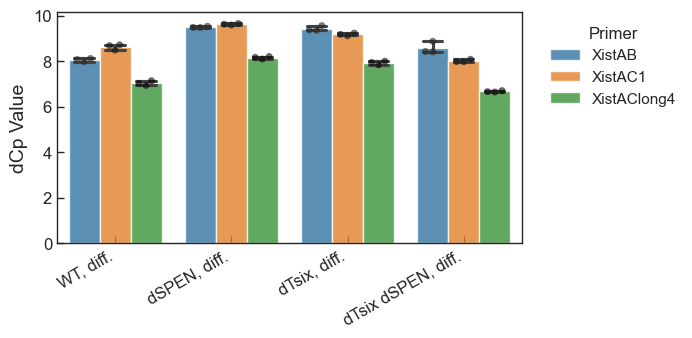

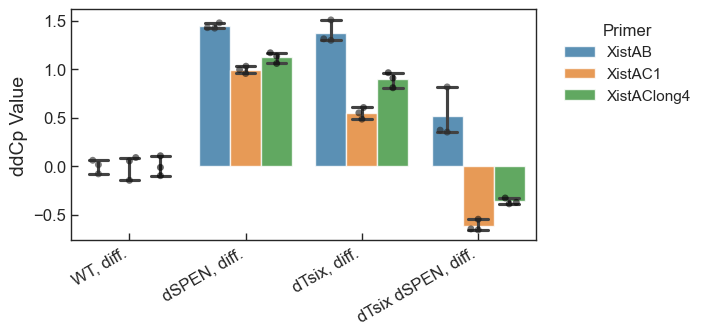

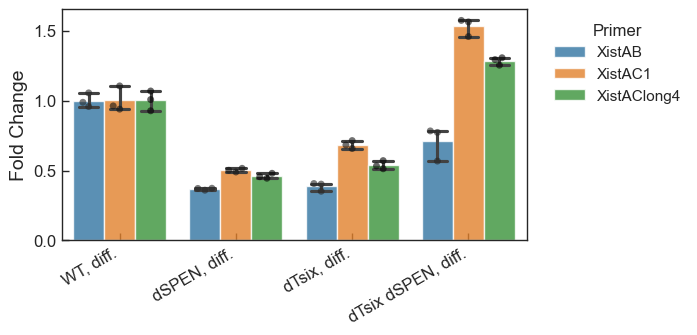

In [22]:
data_dir = "/Volumes/guttman/users/gmgao/Data_qPCR/20260131-dTsix series dRex1 series MultiXist"

df, primers = process_qpcr_csv(os.path.join(data_dir, "20260131-dTsixSeries.csv"))
plot_final_results(
    df,
    primers,
    condition_order=[
        "WT, diff.",
        "dSPEN, diff.",
        "dTsix, diff.",
        "dTsix dSPEN, diff.",
    ],
    primer_order=[
        "XistAB",
        "XistAC1",
        "XistAClong4",
    ],
    save_tag="dTsixSeries_MultiXist",
    save_folder=data_dir,
)